In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import pathlib
import os

In [0]:
dataset,info=tfds.load('oxford_iiit_pet:3.1.0',with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteQCJXN6/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteQCJXN6/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0. Subsequent calls will reuse this data.


In [0]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.1.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.
',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and J

In [0]:
train_data_len=info.splits['train'].num_examples
test_data_len=info.splits['test'].num_examples

In [0]:
def load_image(datapoint):

  img=tf.image.resize(datapoint['image'],(128,128))
  mask=tf.image.resize(datapoint['segmentation_mask'],(128,128))

  img=tf.cast(img,tf.float32) #convert.image.dtype
  img=img/255

  mask-=1

  return img,mask

In [0]:
# 훈련, 검증 데이터셋 정의

train_dataset=dataset['train'].map(load_image)
train_dataset=train_dataset.repeat()  # repeat(step_n) : 원하는 epoch 수를 넣을 수 있다. 아무런 파라미터를 주지 않는다면 iteration이 무제한으로 돌아간다.
train_dataset=train_dataset.batch(16)

valid_dataset=dataset['test'].map(load_image)
valid_dataset=valid_dataset.repeat()
valid_dataset=valid_dataset.batch(1)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


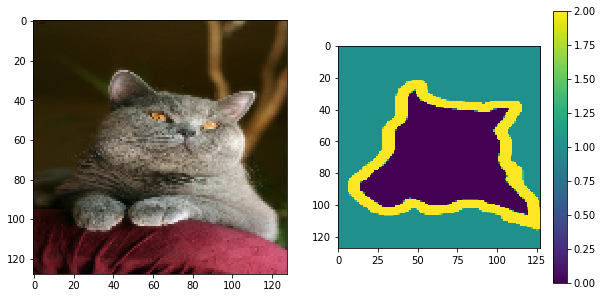

In [0]:
plt.figure(figsize=(10,5))

for img,mask in train_dataset.take(1):
  print(type(img))
  print(type(mask))


plt.subplot(1,2,1)
plt.imshow(img[2])
plt.subplot(1,2,2)
plt.imshow(np.squeeze(mask[2],axis=2))

plt.colorbar()

plt.show()

In [0]:
train_dataset

<DatasetV1Adapter shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

In [0]:
train_dataset.take(1)

<DatasetV1Adapter shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

In [0]:
def REDNet(num_layers):

  conv_layers=[]
  deconv_layers=[]
  residual_layers=[]

  # 입력 레이어 정의
  inputs=keras.layers.Input(shape=(None,None,3))

  conv_layers.append(keras.layers.Conv2D(filters=3,kernel_size=3,padding='same',activation='relu'))
  for i in range(num_layers-1):
    conv_layers.append(keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
    deconv_layers.append(keras.layers.Conv2DTranspose(filters=64,kernel_size=3,padding='same',activation='relu'))
  deconv_layers.append(keras.layers.Conv2DTranspose(filters=3,kernel_size=3,padding='same',activation='softmax'))

  x=conv_layers[0](inputs)

  # encoder
  for i in range(num_layers-1):
    x=conv_layers[i+1](x)
    if i%2==0:
      residual_layers.append(x) # 두번마다 output을 reidual_layers에 apped

  # decoder
  for i in range(num_layers-1):
    if(i%2==1):
      x=keras.layers.Add()([x,residual_layers.pop()])
      x=keras.layers.Activation('relu')(x) # 두번마다 residual 값 더함
    x=deconv_layers[i](x)

  x=deconv_layers[-1](x)

  model=keras.Model(inputs=inputs,outputs=x)
  
  return model

In [0]:
model=REDNet(15)
model.compile(optimizer=tf.optimizers.Adam(0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [0]:
history=model.fit_generator(train_dataset,epochs=20,steps_per_epoch=train_data_len//16,validation_data=valid_dataset,validation_steps=test_data_len,verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Train for 230 steps, validate for 3669 steps
Epoch 1/20
230/230 - 173s - loss: 0.8589 - accuracy: 0.5924 - val_loss: 0.8439 - val_accuracy: 0.5824
Epoch 2/20
230/230 - 168s - loss: 0.7371 - accuracy: 0.6614 - val_loss: 0.7596 - val_accuracy: 0.6559
Epoch 3/20
230/230 - 168s - loss: 0.6687 - accuracy: 0.7078 - val_loss: 0.6512 - val_accuracy: 0.7248
Epoch 4/20
230/230 - 168s - loss: 0.6257 - accuracy: 0.7314 - val_loss: 0.6067 - val_accuracy: 0.7452
Epoch 5/20
230/230 - 168s - loss: 0.5910 - accuracy: 0.7489 - val_loss: 0.5652 - val_accuracy: 0.7594
Epoch 6/20
230/230 - 168s - loss: 0.5637 - accuracy: 0.7618 - val_loss: 0.5432 - val_accuracy: 0.7693
Epoch 7/20
230/230 - 168s - loss: 0.5465 - accuracy: 0.7698 - val_loss: 0.5239 - val_accuracy: 0.7799
Epoch 8/20
230/230 - 168s - loss: 0.5305 - accuracy: 0.7771 - val_loss: 0.5115 - val_accuracy: 0.7865
Epoch 9/20
230/230 - 168s - loss: 0.5179 - accuracy: 0.7827 - val_loss: 0.5019 - val_accuracy: 0.7910
Epoch 10/20
230/230 - 168s - loss: 0.

In [0]:
plt.figure(figsize=(12,12))

for idx, (img,mask) in enumerate(valid_dataset.take(3)):
  plt.subplot(3,3,idx*3+1)
  plt.imshow(img[0])

  plt.subplot(3,3,idx*3+2)
  plt.imshow(np.squeeze(mask[0],axis=2))

  plt.subplot(3,3,idx*3+3)
  predict=tf.argmax(model.predixt(img),axis=-1)
  plt.imshow(np.squeeze(predict[0],axis=0))

In [0]:
plt.figure(figsize=(12,12))

for idx, (img,mask) in enumerate(dataset['test'].take(3)):

  img=datapoint['image']
  mask=datapoint['segmentation_mask']

  img=tf.cast(img,tf.float32) #convert.image.dtype
  img=img/255
  mask-=1

  plt.subplot(3,3,idx*3+1)
  plt.imshow(img)

  plt.subplot(3,3,idx*3+2)
  plt.imshow(np.squeeze(mask,axis=2))

  plt.subplot(3,3,idx*3+3)
  predict=tf.argmax(model.predixt(img),axis=-1)
  plt.imshow(np.squeeze(predict[0],axis=0))